In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Data Collection
def fetch_stock_data(symbol='AAPL', period='2y'):
    """Fetch historical stock data using yfinance"""
    try:
        import yfinance as yf
        print(f"Fetching data for {symbol}...")
        stock = yf.Ticker(symbol)
        df = stock.history(period=period)
        df.reset_index(inplace=True)
        print(f"Downloaded {len(df)} records")
        return df
    except Exception as e:
        print(f"Error fetching data: {e}")
        # Generate synthetic data for testing
        return generate_synthetic_data()

In [3]:
def generate_synthetic_data(n_samples=500):
    """Generate synthetic OHLC data for testing"""
    dates = pd.date_range(end=datetime.now(), periods=n_samples, freq='D')
    base_price = 100
    data = []
    
    for i in range(n_samples):
        open_price = base_price + np.random.randn() * 2
        close_price = open_price + np.random.randn() * 3
        high_price = max(open_price, close_price) + abs(np.random.randn())
        low_price = min(open_price, close_price) - abs(np.random.randn())
        volume = np.random.randint(1000000, 10000000)
        
        data.append({
            'Date': dates[i],
            'Open': open_price,
            'High': high_price,
            'Low': low_price,
            'Close': close_price,
            'Volume': volume
        })
        base_price = close_price
    
    return pd.DataFrame(data)

In [4]:
def calculate_technical_indicators(df):
    """Calculate technical indicators"""
    # Moving Averages
    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    df['SMA_30'] = df['Close'].rolling(window=30).mean()
    df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
    
    # RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # MACD
    ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    # Bollinger Bands
    df['BB_middle'] = df['Close'].rolling(window=20).mean()
    bb_std = df['Close'].rolling(window=20).std()
    df['BB_upper'] = df['BB_middle'] + (bb_std * 2)
    df['BB_lower'] = df['BB_middle'] - (bb_std * 2)
    
    return df

In [5]:
def detect_candlestick_patterns(df):
    """Detect key candlestick patterns"""
    # Candle body and shadows
    df['body'] = abs(df['Close'] - df['Open'])
    df['upper_shadow'] = df['High'] - df[['Open', 'Close']].max(axis=1)
    df['lower_shadow'] = df[['Open', 'Close']].min(axis=1) - df['Low']
    df['range'] = df['High'] - df['Low']
    
    # Doji: small body relative to range
    df['Doji'] = (df['body'] <= df['range'] * 0.1).astype(int)
    
    # Hammer: small body, long lower shadow
    df['Hammer'] = ((df['lower_shadow'] >= df['body'] * 2) &
                    (df['upper_shadow'] <= df['body'] * 0.3)).astype(int)
    
    # Shooting Star: small body, long upper shadow
    df['Shooting_Star'] = ((df['upper_shadow'] >= df['body'] * 2) &
                           (df['lower_shadow'] <= df['body'] * 0.3)).astype(int)
    
    # Engulfing patterns
    df['Bullish_Engulfing'] = 0
    df['Bearish_Engulfing'] = 0
    
    for i in range(1, len(df)):
        prev_body = abs(df.iloc[i-1]['Close'] - df.iloc[i-1]['Open'])
        curr_body = abs(df.iloc[i]['Close'] - df.iloc[i]['Open'])
        
        if (df.iloc[i-1]['Close'] < df.iloc[i-1]['Open'] and
            df.iloc[i]['Close'] > df.iloc[i]['Open'] and
            curr_body > prev_body):
            df.at[i, 'Bullish_Engulfing'] = 1
            
        if (df.iloc[i-1]['Close'] > df.iloc[i-1]['Open'] and
            df.iloc[i]['Close'] < df.iloc[i]['Open'] and
            curr_body > prev_body):
            df.at[i, 'Bearish_Engulfing'] = 1
    
    return df


In [6]:
def prepare_features(df):
    """Prepare feature matrix"""
    df = calculate_technical_indicators(df)
    df = detect_candlestick_patterns(df)
    
    # Create target variable (1 if price goes up next day, 0 otherwise)
    df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
    
    # Drop rows with NaN values
    df = df.dropna()
    
    feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume',
                    'SMA_10', 'SMA_30', 'EMA_10', 'RSI', 'MACD', 'Signal',
                    'BB_middle', 'BB_upper', 'BB_lower', 'body', 'upper_shadow',
                    'lower_shadow', 'Doji', 'Hammer', 'Shooting_Star',
                    'Bullish_Engulfing', 'Bearish_Engulfing']
    
    return df, feature_cols

In [7]:
# Data Preprocessing
def create_sequences(data, target, sequence_length=20):
    """Create sequences for LSTM training"""
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(target[i+sequence_length])
    return np.array(X), np.array(y)


In [8]:
def normalize_data(train_data, test_data):
    """Normalize features using Min-Max scaling"""
    train_min = train_data.min(axis=0)
    train_max = train_data.max(axis=0)
    
    train_normalized = (train_data - train_min) / (train_max - train_min + 1e-8)
    test_normalized = (test_data - train_min) / (train_max - train_min + 1e-8)
    
    return train_normalized, test_normalized

In [9]:
# Model Architecture
def build_cnn_lstm_model(input_shape, num_classes=2):
    """Build hybrid CNN-LSTM model using TensorFlow/Keras"""
    try:
        from tensorflow import keras
        from tensorflow.keras import layers
        
        model = keras.Sequential([
            # CNN layers for feature extraction
            layers.Conv1D(filters=64, kernel_size=3, activation='relu',
                         input_shape=input_shape),
            layers.MaxPooling1D(pool_size=2),
            layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
            layers.MaxPooling1D(pool_size=2),
            layers.Dropout(0.3),
            
            # LSTM layers for temporal patterns
            layers.LSTM(100, return_sequences=True),
            layers.Dropout(0.3),
            layers.LSTM(50),
            layers.Dropout(0.3),
            
            # Dense layers
            layers.Dense(50, activation='relu'),
            layers.Dense(num_classes, activation='softmax')
        ])
        
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    except ImportError:
        print("TensorFlow not installed. Please install: pip install tensorflow")
        return None

In [10]:
# Training and Evaluation
def train_model(X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
    """Train the model"""
    print(f"\nTraining data shape: {X_train.shape}")
    print(f"Testing data shape: {X_test.shape}")
    
    model = build_cnn_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))
    
    if model is None:
        return None
    
    print("\nModel Architecture:")
    model.summary()
    
    try:
        from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
        
        # Callbacks
        early_stop = EarlyStopping(monitor='val_loss', patience=10,
                                   restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                      patience=5, min_lr=1e-7)
        
        print("\nTraining model...")
        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop, reduce_lr],
            verbose=1
        )
        
        return model, history
    except Exception as e:
        print(f"Training error: {e}")
        return None, None


In [11]:
def evaluate_model(model, X_test, y_test):
    """Evaluate model performance"""
    try:
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
        from sklearn.metrics import confusion_matrix, classification_report
        
        # Predictions
        y_pred_proba = model.predict(X_test)
        y_pred = np.argmax(y_pred_proba, axis=1)
        
        # Metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        print("\n" + "="*50)
        print("MODEL EVALUATION RESULTS")
        print("="*50)
        print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"Precision: {precision:.4f}")
        print(f"Recall:    {recall:.4f}")
        print(f"F1-Score:  {f1:.4f}")
        print("\nConfusion Matrix:")
        print(confusion_matrix(y_test, y_pred))
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred,
                                    target_names=['Down', 'Up']))
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'predictions': y_pred
        }
    except ImportError:
        print("scikit-learn not installed. Please install: pip install scikit-learn")
        return None


In [12]:
def plot_candlestick_chart(df, symbol, show_patterns=True):
    """
    Create TradingView-style candlestick chart with volume and indicators
    for each year separately
    """
    try:
        import matplotlib.pyplot as plt
        import matplotlib.patches as mpatches
        from matplotlib.patches import Rectangle
        from matplotlib.lines import Line2D
        import matplotlib.dates as mdates
        
        # Ensure 'Date' column is datetime type
        df['Date'] = pd.to_datetime(df['Date'])
        
        # Get unique years
        years = df['Date'].dt.year.unique()
        
        for year in years:
            print(f"\nPlotting chart for {year}...")
            
            # Filter data for current year
            df_year = df[df['Date'].dt.year == year].copy()
            df_year.reset_index(drop=True, inplace=True)
            
            # Create figure with subplots
            fig = plt.figure(figsize=(16, 12))
            gs = fig.add_gridspec(6, 1, hspace=0.05, height_ratios=[3, 1, 1, 1, 1, 1])
            
            ax1 = fig.add_subplot(gs[0])  # Candlesticks + Indicators
            ax2 = fig.add_subplot(gs[1], sharex=ax1)  # Volume
            ax3 = fig.add_subplot(gs[2], sharex=ax1)  # RSI
            ax4 = fig.add_subplot(gs[3], sharex=ax1)  # MACD
            ax5 = fig.add_subplot(gs[4], sharex=ax1)  # Bollinger Bands
            ax6 = fig.add_subplot(gs[5], sharex=ax1)  # Stochastic Oscillator
            
            # Set dark background (TradingView style)
            fig.patch.set_facecolor('#0e0e0e')
            for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
                ax.set_facecolor('#131722')
                ax.tick_params(colors='#787b86', which='both')
                ax.spines['bottom'].set_color('#2a2e39')
                ax.spines['top'].set_color('#2a2e39')
                ax.spines['right'].set_color('#2a2e39')
                ax.spines['left'].set_color('#2a2e39')
            
            # ========== CANDLESTICK CHART ==========
            for idx, row in df_year.iterrows():
                # Determine candle color
                if row['Close'] >= row['Open']:
                    color = '#26a69a'  # Green (bullish)
                    body_color = '#26a69a'
                else:
                    color = '#ef5350'  # Red (bearish)
                    body_color = '#ef5350'
                
                # Draw high-low line (wick)
                ax1.plot([idx, idx], [row['Low'], row['High']], 
                        color=color, linewidth=1, solid_capstyle='round')
                
                # Draw open-close rectangle (body)
                height = abs(row['Close'] - row['Open'])
                bottom = min(row['Open'], row['Close'])
                
                rect = Rectangle((idx - 0.4, bottom), 0.8, height,
                               facecolor=body_color, edgecolor=body_color,
                               linewidth=1, alpha=0.9)
                ax1.add_patch(rect)
                
                # Mark candlestick patterns
                if show_patterns and 'Doji' in df_year.columns:
                    y_pos = row['High'] * 1.002
                    
                    if row['Doji'] == 1:
                        ax1.text(idx, y_pos, '◆', fontsize=12, 
                                color='#ffeb3b', ha='center', va='bottom')
                    
                    if row['Hammer'] == 1:
                        ax1.text(idx, y_pos, '🔨', fontsize=10, 
                                ha='center', va='bottom')
                    
                    if row['Shooting_Star'] == 1:
                        ax1.text(idx, y_pos, '⭐', fontsize=10, 
                                ha='center', va='bottom')
                    
                    if row['Bullish_Engulfing'] == 1:
                        ax1.text(idx, y_pos, '↑', fontsize=14, 
                                color='#00ff00', ha='center', va='bottom', weight='bold')
                    
                    if row['Bearish_Engulfing'] == 1:
                        ax1.text(idx, y_pos, '↓', fontsize=14, 
                                color='#ff0000', ha='center', va='bottom', weight='bold')
            
            # Plot moving averages
            if 'SMA_10' in df_year.columns:
                ax1.plot(df_year.index, df_year['SMA_10'], 
                        color='#2962ff', linewidth=1.5, label='SMA 10', alpha=0.8)
            if 'SMA_30' in df_year.columns:
                ax1.plot(df_year.index, df_year['SMA_30'], 
                        color='#ff6d00', linewidth=1.5, label='SMA 30', alpha=0.8)
            if 'EMA_10' in df_year.columns:
                ax1.plot(df_year.index, df_year['EMA_10'], 
                        color='#00e676', linewidth=1, label='EMA 10', alpha=0.6, linestyle='--')
            
            ax1.set_title(f'{symbol} - {year} Candlestick Chart (TradingView Style)', 
                         color='#d1d4dc', fontsize=16, weight='bold', pad=20)
            ax1.set_ylabel('Price (USD)', color='#787b86', fontsize=11)
            ax1.legend(loc='upper left', framealpha=0.3, facecolor='#1e222d', 
                      edgecolor='#2a2e39', labelcolor='#787b86')
            ax1.grid(True, alpha=0.1, color='#2a2e39')
            ax1.tick_params(labelbottom=False)
            
            # ========== VOLUME CHART ==========
            colors_volume = ['#26a69a' if row['Close'] >= row['Open'] else '#ef5350' 
                            for _, row in df_year.iterrows()]
            ax2.bar(df_year.index, df_year['Volume'], color=colors_volume, alpha=0.6, width=0.8)
            ax2.set_ylabel('Volume', color='#787b86', fontsize=10)
            ax2.ticklabel_format(style='plain', axis='y')
            ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
            ax2.grid(True, alpha=0.1, color='#2a2e39')
            ax2.tick_params(labelbottom=False)
            
            # ========== RSI CHART ==========
            if 'RSI' in df_year.columns:
                ax3.plot(df_year.index, df_year['RSI'], color='#2962ff', linewidth=1.5)
                ax3.axhline(70, color='#ef5350', linestyle='--', linewidth=1, alpha=0.5)
                ax3.axhline(30, color='#26a69a', linestyle='--', linewidth=1, alpha=0.5)
                ax3.fill_between(df_year.index, 30, 70, color='#787b86', alpha=0.05)
                ax3.set_ylabel('RSI', color='#787b86', fontsize=10)
                ax3.set_ylim(0, 100)
                ax3.grid(True, alpha=0.1, color='#2a2e39')
                ax3.tick_params(labelbottom=False)
            
            # ========== MACD CHART ==========
            if 'MACD' in df_year.columns:
                ax4.plot(df_year.index, df_year['MACD'], 
                        color='#2962ff', linewidth=1.5, label='MACD')
                ax4.plot(df_year.index, df_year['Signal'], 
                        color='#ff6d00', linewidth=1.5, label='Signal')
                
                # MACD histogram
                histogram = df_year['MACD'] - df_year['Signal']
                colors_macd = ['#26a69a' if val >= 0 else '#ef5350' for val in histogram]
                ax4.bar(df_year.index, histogram, color=colors_macd, alpha=0.5, width=0.8)
                
                ax4.axhline(0, color='#787b86', linewidth=1, alpha=0.3)
                ax4.set_ylabel('MACD', color='#787b86', fontsize=10)
                ax4.legend(loc='upper left', framealpha=0.3, facecolor='#1e222d',
                          edgecolor='#2a2e39', labelcolor='#787b86', fontsize=9)
                ax4.grid(True, alpha=0.1, color='#2a2e39')
                ax4.tick_params(labelbottom=False)
            
            # ========== Bollinger Bands ==========
            if 'BB_upper' in df_year.columns:
                ax5.plot(df_year.index, df_year['BB_upper'], 
                        color='#9c27b0', linewidth=1, alpha=0.5, linestyle=':')
                ax5.plot(df_year.index, df_year['BB_lower'], 
                                                color='#9c27b0', linewidth=1, alpha=0.5, linestyle=':')
                ax5.plot(df_year.index, df_year['BB_middle'], 
                        color='#2962ff', linewidth=1.5, label='BB Middle')
                ax5.fill_between(df_year.index, df_year['BB_upper'], df_year['BB_lower'],
                               color='#9c27b0', alpha=0.05)
                ax5.set_ylabel('Bollinger Bands', color='#787b86', fontsize=10)
                ax5.legend(loc='upper left', framealpha=0.3, facecolor='#1e222d',
                          edgecolor='#2a2e39', labelcolor='#787b86', fontsize=9)
                ax5.grid(True, alpha=0.1, color='#2a2e39')
                ax5.tick_params(labelbottom=False)
            
            # ========== Stochastic Oscillator ==========
            if 'Stochastic' in df_year.columns and 'Stochastic_Signal' in df_year.columns:
                ax6.plot(df_year.index, df_year['Stochastic'], 
                        color='#2962ff', linewidth=1.5, label='%K')
                ax6.plot(df_year.index, df_year['Stochastic_Signal'], 
                        color='#ff6d00', linewidth=1.5, label='%D')
                ax6.axhline(80, color='#ef5350', linestyle='--', linewidth=1, alpha=0.5)
                ax6.axhline(20, color='#26a69a', linestyle='--', linewidth=1, alpha=0.5)
                ax6.fill_between(df_year.index, 20, 80, color='#787b86', alpha=0.05)
                ax6.set_ylabel('Stochastic', color='#787b86', fontsize=10)
                ax6.set_ylim(0, 100)
                ax6.legend(loc='upper left', framealpha=0.3, facecolor='#1e222d',
                          edgecolor='#2a2e39', labelcolor='#787b86', fontsize=9)
                ax6.grid(True, alpha=0.1, color='#2a2e39')
            
            # Format x-axis dates
            date_labels = df_year['Date'].dt.strftime('%Y-%m-%d')
            step = max(1, len(df_year) // 10)
            ax6.set_xticks(range(0, len(df_year), step))
            ax6.set_xticklabels(date_labels[::step], rotation=45, ha='right')
            
            plt.tight_layout()
            plt.show()
        
    except Exception as e:
        print(f"Error: {e}")

CANDLESTICK PATTERN PREDICTION MODEL



Enter stock ticker (e.g., AAPL, TSLA, RELIANCE.NS):  reliance.ns



Fetching data for RELIANCE.NS...
Fetching data for RELIANCE.NS...
Downloaded 1238 records

Dataset shape: (1238, 8)
Date range: 2020-10-15 00:00:00+05:30 to 2025-10-15 00:00:00+05:30

VISUALIZING CANDLESTICK CHART



Do you want to visualize the candlestick chart? (yes/no):  yes



Plotting chart for 2020...


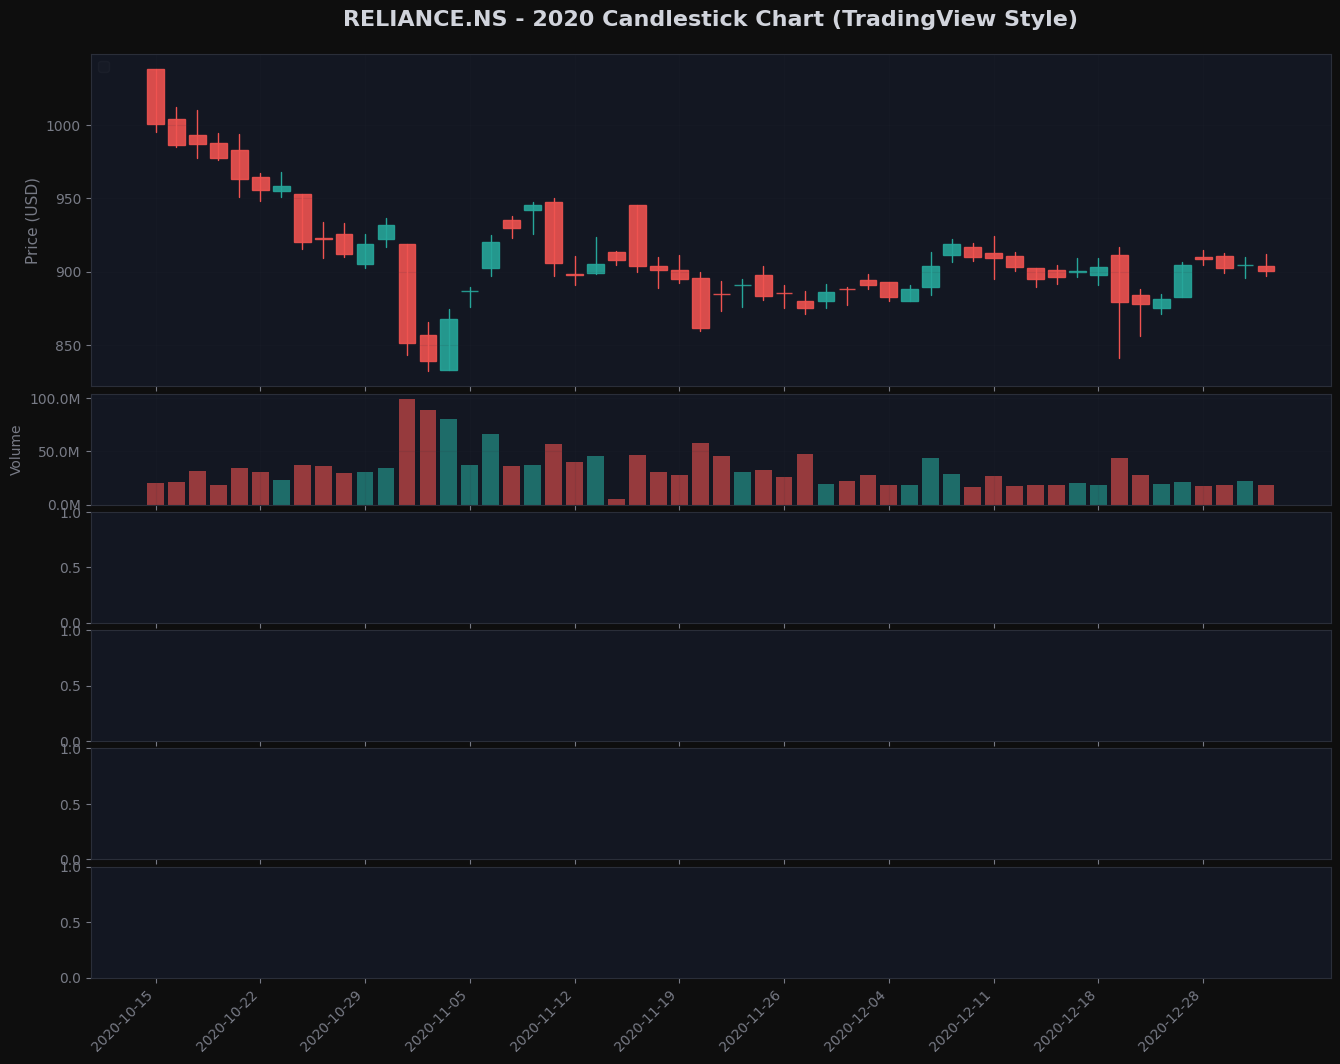


Plotting chart for 2021...


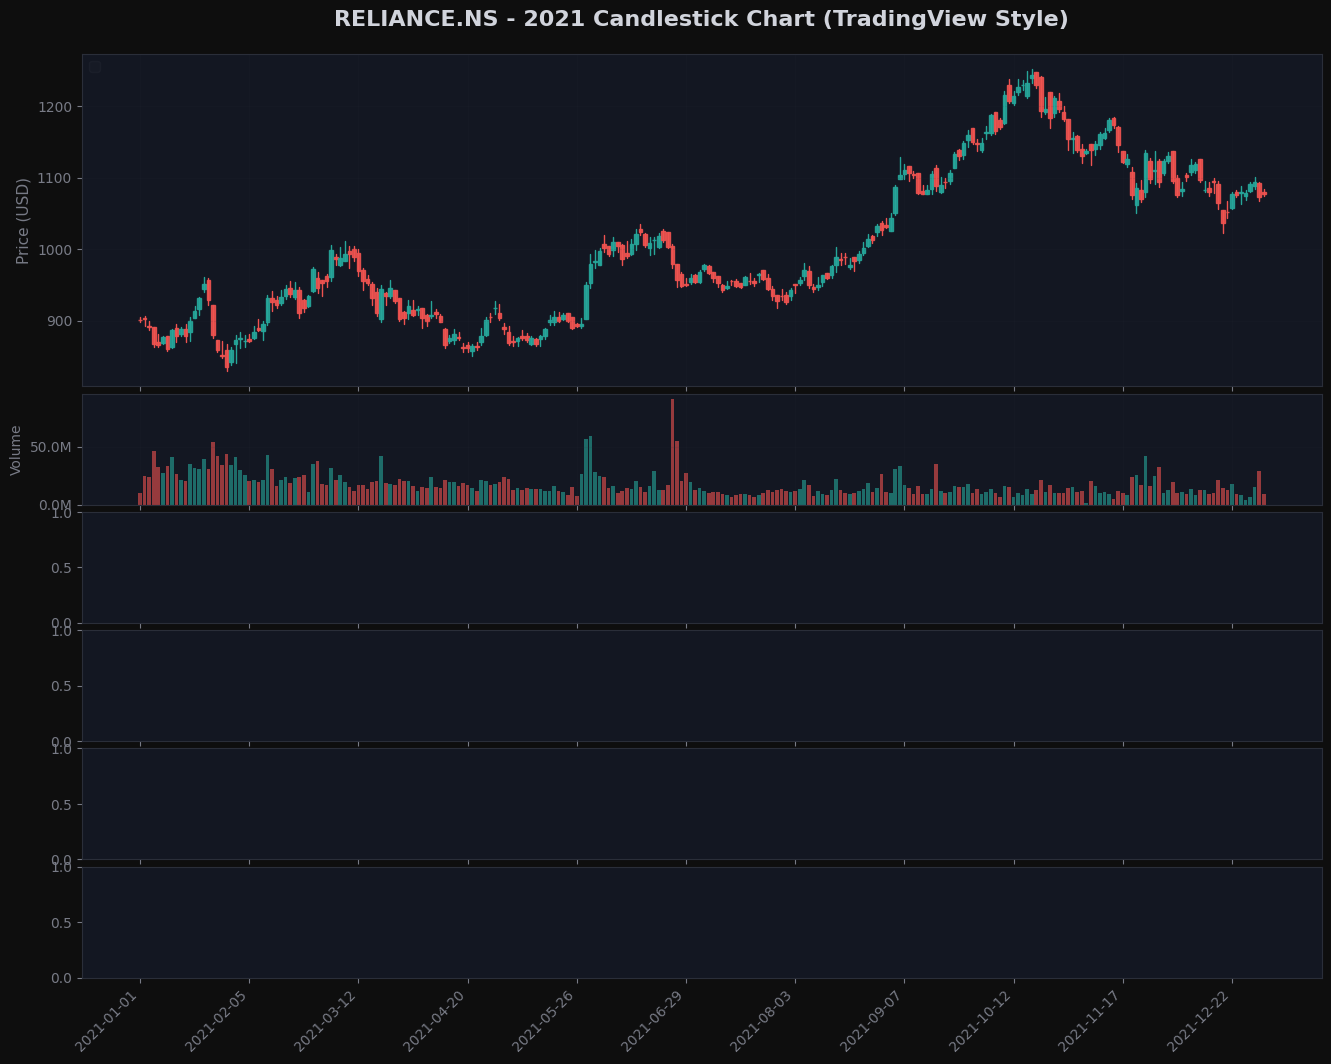


Plotting chart for 2022...


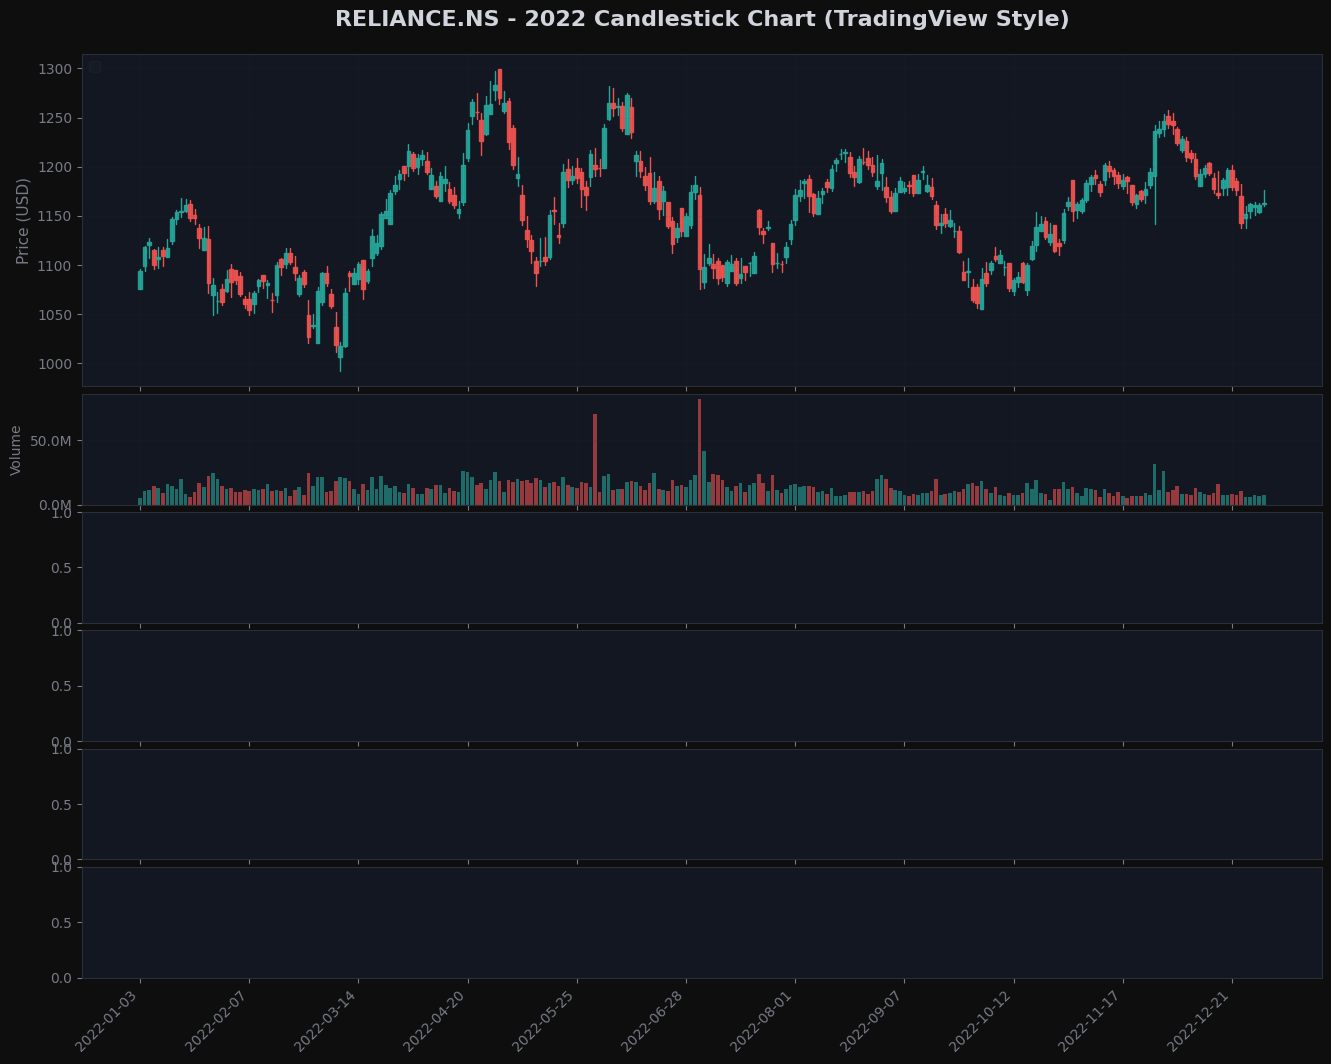


Plotting chart for 2023...


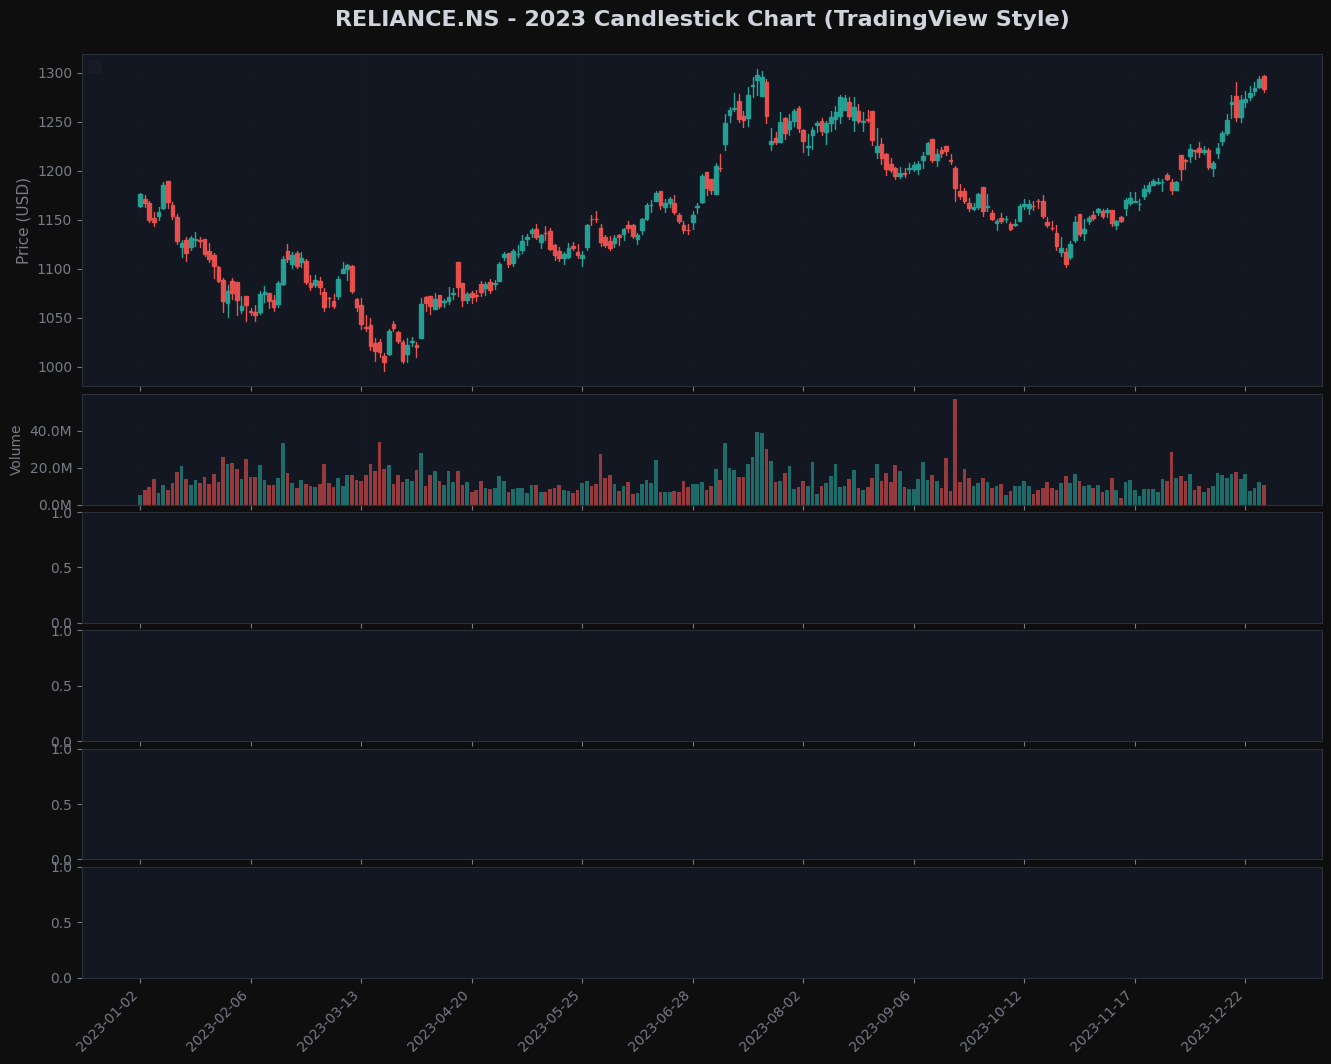


Plotting chart for 2024...


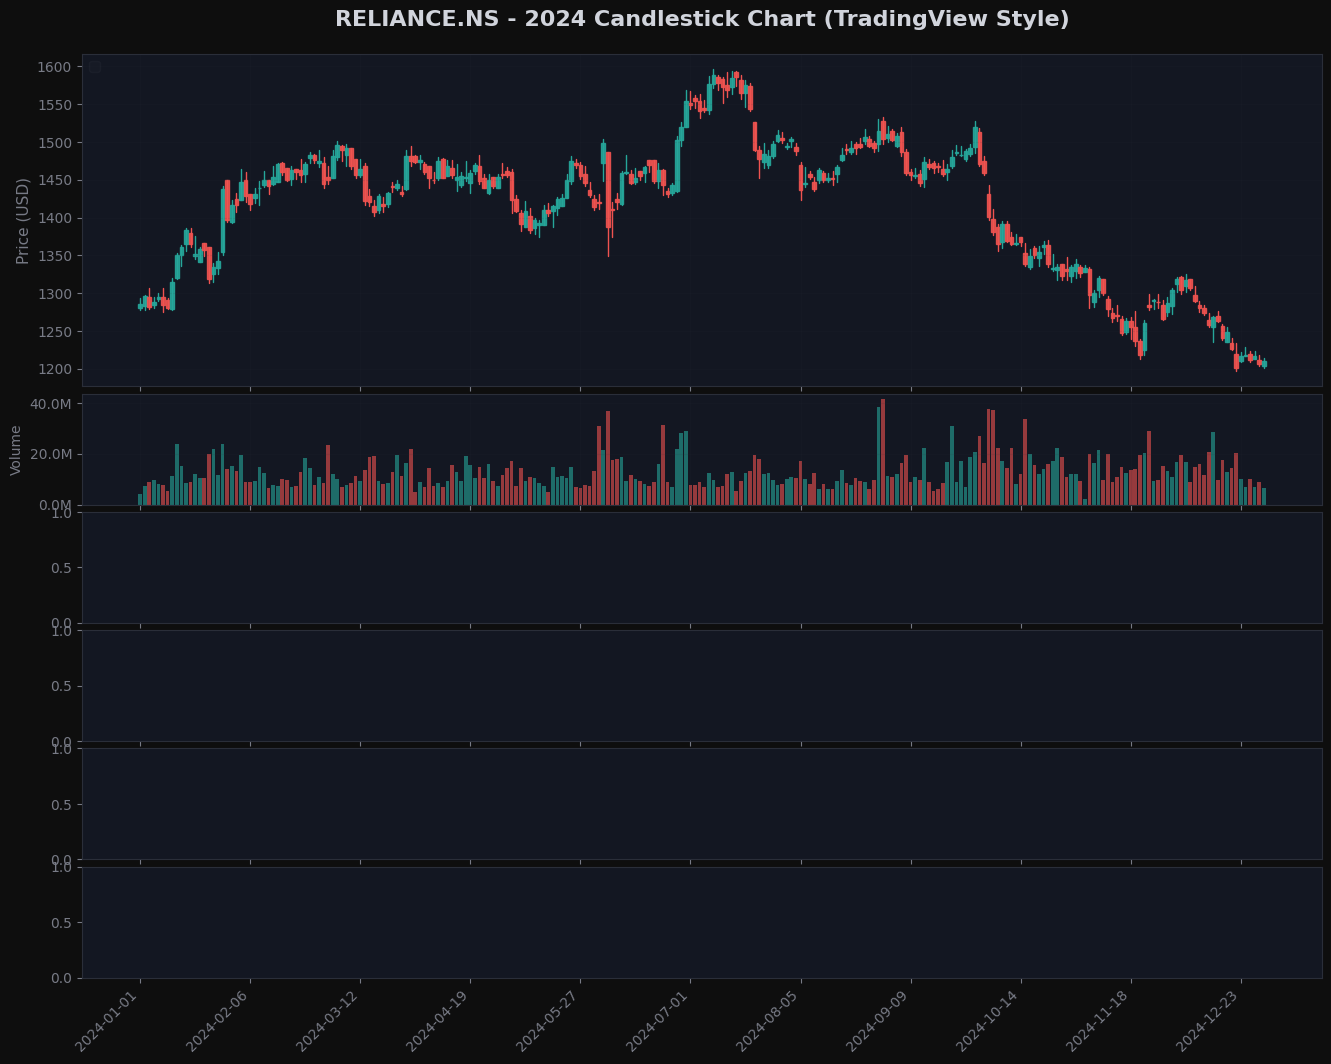


Plotting chart for 2025...


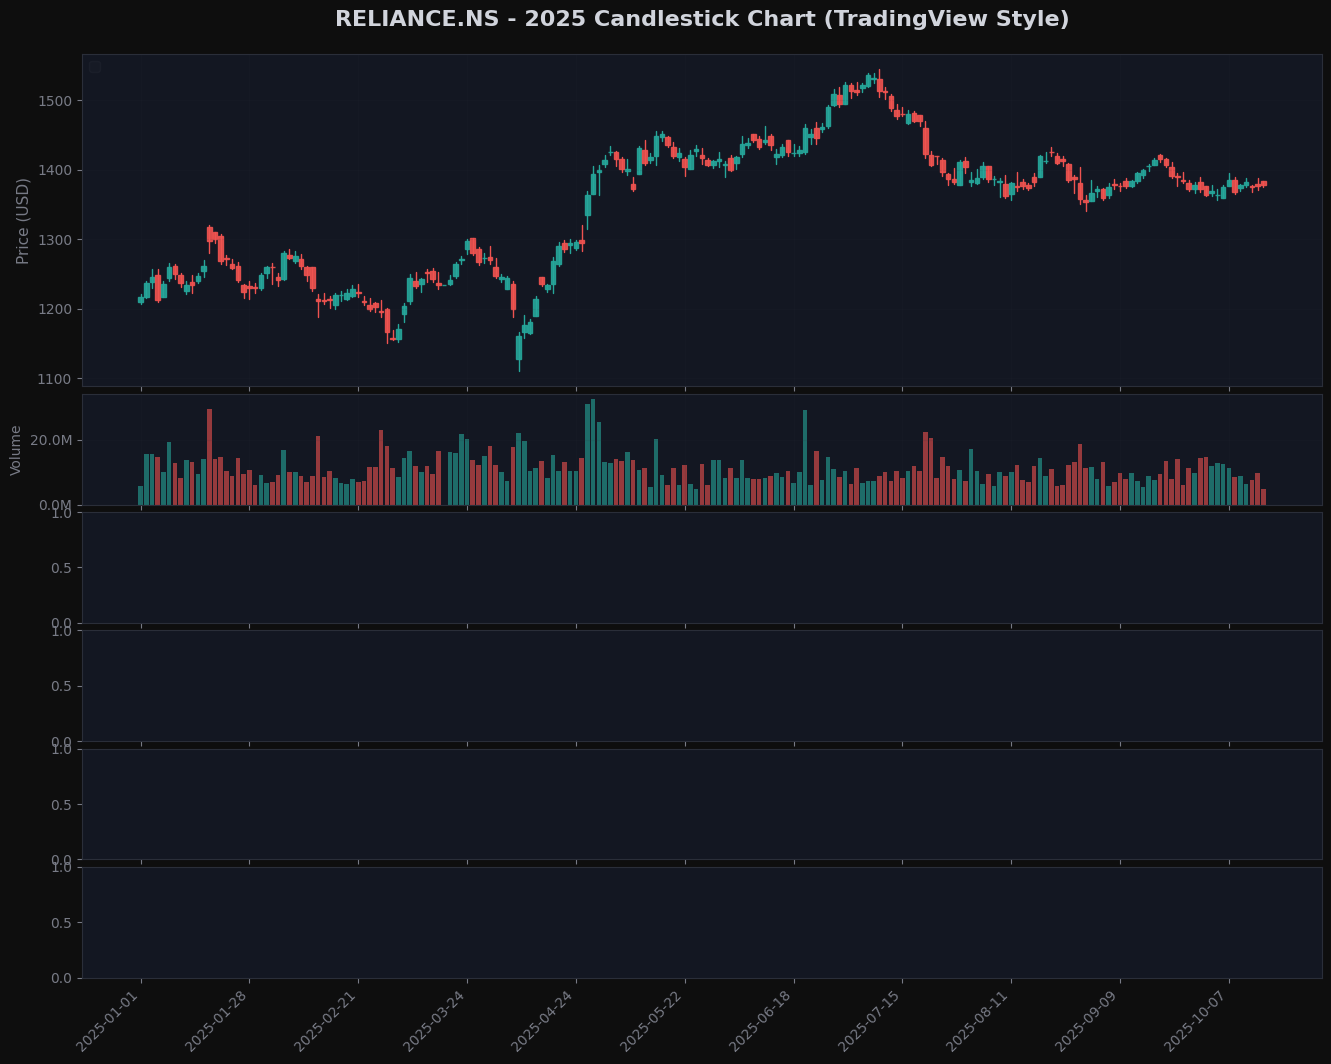


Engineering features...
Total features: 22

Sequence length: 20
Training sequences: 947
Testing sequences: 222

Training data shape: (947, 20, 22)
Testing data shape: (222, 20, 22)

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 18, 64)              │           4,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 9, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 7, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 3, 100)              │          91,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 3, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 153,444 (599.39 KB)

 Trainable params: 153,444 (599.39 KB)

 Non-trainable params: 0 (0.00 B)


Training model...
Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 98ms/step - accuracy: 0.5143 - loss: 0.6977 - val_accuracy: 0.5045 - val_loss: 0.6948 - learning_rate: 0.0010
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5238 - loss: 0.6928 - val_accuracy: 0.5045 - val_loss: 0.6944 - learning_rate: 0.0010
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.5238 - loss: 0.6920 - val_accuracy: 0.5045 - val_loss: 0.6940 - learning_rate: 0.0010
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5206 - loss: 0.6925 - val_accuracy: 0.5270 - val_loss: 0.6930 - learning_rate: 0.0010
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5238 - loss: 0.6917 - val_accuracy: 0.5045 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5227 - loss: 0.6922 - val_accuracy: 0.5045 - val_loss: 0.6935 - learning_rate: 0.0010
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5248 - lo

In [ ]:
# Main Execution
def main():
    print("="*70)
    print("CANDLESTICK PATTERN PREDICTION MODEL")
    print("="*70)
    
    # Ask user for stock ticker
    stock_symbol = input("\nEnter stock ticker (e.g., AAPL, TSLA, RELIANCE.NS): ").upper()
    
    # 1. Data Collection
    print(f"\nFetching data for {stock_symbol}...")
    df = fetch_stock_data(stock_symbol, period='5y')

    print(f"\nDataset shape: {df.shape}")
    print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

    # ========== VISUALIZATION ==========
    print("\n" + "="*70)
    print("VISUALIZING CANDLESTICK CHART")
    print("="*70)
    
    visualize = input("\nDo you want to visualize the candlestick chart? (yes/no): ").lower()
    if visualize in ['yes', 'y']:
        plot_candlestick_chart(df, stock_symbol, show_patterns=True)
    
    # 2. Feature Engineering
    print("\nEngineering features...")
    df, feature_cols = prepare_features(df)
    print(f"Total features: {len(feature_cols)}")
    
    # 3. Prepare sequences
    sequence_length = 20
    X_data = df[feature_cols].values
    y_data = df['Target'].values
    
    # Split data (80-20)
    split_idx = int(len(X_data) * 0.8)
    X_train_raw = X_data[:split_idx]
    X_test_raw = X_data[split_idx:]
    y_train_raw = y_data[:split_idx]
    y_test_raw = y_data[split_idx:]
    
    # Normalize
    X_train_norm, X_test_norm = normalize_data(X_train_raw, X_test_raw)
    
    # Create sequences
    X_train, y_train = create_sequences(X_train_norm, y_train_raw, sequence_length)
    X_test, y_test = create_sequences(X_test_norm, y_test_raw, sequence_length)
    
    print(f"\nSequence length: {sequence_length}")
    print(f"Training sequences: {len(X_train)}")
    print(f"Testing sequences: {len(X_test)}")
    
    # 4. Train Model
    model, history = train_model(X_train, y_train, X_test, y_test,
                                 epochs=50, batch_size=32)
    
    if model is None:
        print("\nModel training failed. Please install required packages:")
        print("pip install tensorflow scikit-learn yfinance pandas numpy")
        return
    
    # 5. Evaluate Model
    results = evaluate_model(model, X_test, y_test)
    
    # 6. Save Model
    if results:
        try:
            model.save('candlestick_model.h5')
            print("\n✓ Model saved as 'candlestick_model.h5'")
            print("\nTo load model:")
            print("from tensorflow import keras")
            print("model = keras.models.load_model('candlestick_model.h5')")
        except Exception as e:
            print(f"\nError saving model: {e}")
    
    # 7. Sample Prediction
    print("\n" + "="*50)
    print("SAMPLE PREDICTION")
    print("="*50)
    sample_idx = np.random.randint(0, len(X_test))
    sample = X_test[sample_idx:sample_idx+1]
    prediction = model.predict(sample)
    predicted_class = np.argmax(prediction)
    confidence = prediction[0][predicted_class]
    actual_class = y_test[sample_idx]
    
    print(f"Predicted: {'UP ↑' if predicted_class == 1 else 'DOWN ↓'} "
          f"(Confidence: {confidence*100:.2f}%)")
    print(f"Actual:    {'UP ↑' if actual_class == 1 else 'DOWN ↓'}")
    print(f"Result:    {'✓ CORRECT' if predicted_class == actual_class else '✗ INCORRECT'}")
    
    print("\n" + "="*70)
    print("TRAINING COMPLETE")
    print("="*70)

if __name__ == "__main__":
    main()